In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('preprocessed/data1h.csv', index_col=0, parse_dates=True)
df

,MpKrakZloRog,AirTemp,rainIntensity,rainAccumulation,maxWindSpeed,RelativeHumidity,WindSpeed,AirPressure,year,day_off,month_sin,month_cos,hour_sin,hour_cos,sin_WindDir,cos_WindDir
2016-01-01 01:00:00,342.9240,-9.153333,0.000000,0.00,1.1,71.593333,0.703333,1000.516667,2016,1,5.000000e-01,0.866025,0.258819,0.965926,-0.996195,-0.087156
2016-01-01 02:00:00,329.6600,-9.475000,0.000000,0.00,1.4,71.685000,0.698333,1000.363333,2016,1,5.000000e-01,0.866025,0.500000,0.866025,-0.999848,-0.017452
2016-01-01 03:00:00,322.5390,-9.851667,0.000000,0.00,1.6,71.863333,0.743333,1000.123333,2016,1,5.000000e-01,0.866025,0.707107,0.707107,-0.974370,0.224951
2016-01-01 04:00:00,294.5480,-10.175000,0.000000,0.00,1.4,71.668333,0.661667,1000.190000,2016,1,5.000000e-01,0.866025,0.866025,0.500000,-0.961262,0.275637
2016-01-01 05:00:00,285.5270,-10.160000,0.000000,0.00,1.5,71.786667,0.600000,999.881667,2016,1,5.000000e-01,0.866025,0.965926,0.258819,-0.939693,-0.342020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,29.7133,4.635000,0.000000,0.00,1.6,74.210000,0.866667,980.588333,2023,1,-2.449294e-16,1.000000,-0.965926,0.258819,0.974370,0.224951
2023-12-31 20:00:00,32.3285,4.368333,0.000000,0.00,1.4,74.971667,0.721667,980.480000,2023,1,-2.449294e-16,1.000000,-0.866025,0.500000,0.358368,0.933580
2023-12-31 21:00:00,38.2589,3.943333,0.000000,0.00,1.2,76.206667,0.546667,980.611667,2023,1,-2.449294e-16,1.000000,-0.707107,0.707107,-0.358368,0.933580
2023-12-31 22:00:00,41.0132,3.903333,0.000000,0.00,1.5,76.143333,0.585000,980.510000,2023,1,-2.449294e-16,1.000000,-0.500000,0.866025,-0.515038,0.857167


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Prediction for next hour

In [44]:
def df_to_X_y_singular(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size] # true value
        y.append(label)
    return np.array(X), np.array(y)

In [45]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame({'Predictions': predictions, 'Actual Value': y})
    plt.plot(df['Actual Value'][start:end], label='Actual Value')
    plt.plot(df['Predictions'][start:end], label='Predictions')
    plt.legend()
    plt.show()
    return df, mean_squared_error(y, predictions), r2_score(y, predictions)

In [140]:
X, y = df_to_X_y_singular(df.MpKrakZloRog, window_size=12)

In [141]:
# train_size = 60000
# val_size = 5000
# 
# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size:val_size], y[train_size:val_size]
# X_test, y_test = X[val_size:], y[val_size:]

X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]

In [145]:
model = Sequential()
model.add(InputLayer(shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(16, return_sequences=True)) # more neurons
#model.add(LSTM(64))
# fastest and similar statistics
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
#model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 11, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,745 (131.82 KB)

 Trainable params: 33,745 (131.82 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
cp = ModelCheckpoint('models/finals/singular_1h.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) 

In [148]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 211.9713 - root_mean_squared_error: 14.5432 - val_loss: 42.6633 - val_root_mean_squared_error: 6.5317
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 169.7047 - root_mean_squared_error: 13.0031 - val_loss: 42.2412 - val_root_mean_squared_error: 6.4993
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 141.9440 - root_mean_squared_error: 11.9091 - val_loss: 41.9487 - val_root_mean_squared_error: 6.4768
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 127.8688 - root_mean_squared_error: 11.3046 - val_loss: 40.7231 - val_root_mean_squared_error: 6.3815
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 114.9581 - root_mean_squared_error: 10.7163 - val_loss: 41.8215 - val_root_mean_squared_error: 6.4670
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 115.1648 - root_mean_squared_error: 10.7283 - val_loss: 39.6256 - val_root_mean_squared_error: 6.2949
Epoch 7/20

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


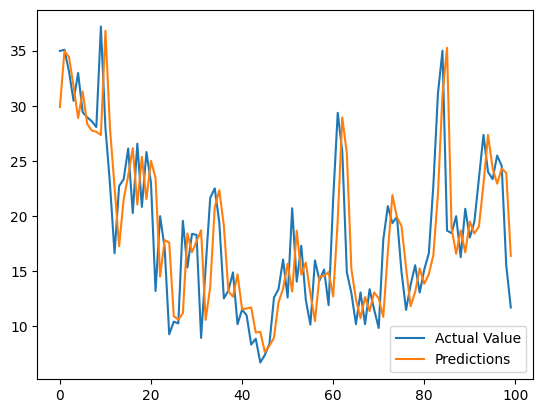

(      Predictions  Actual Value
 0       29.874582       34.9620
 1       34.935848       35.0748
 2       34.424530       33.0905
 3       31.742023       30.4439
 4       28.878502       32.9597
 ...           ...           ...
 5110    21.193100       29.7133
 5111    30.134581       32.3285
 5112    32.800804       38.2589
 5113    38.743622       41.0132
 5114    41.559044       47.8850
 
 [5115 rows x 2 columns],
 np.float64(36.623371321174766),
 0.8570280510695621)

In [149]:
# model = load_model('models/finals/singular_1h.keras')
plot_predictions(model, X_test, y_test, start=0, end=100)

## Prediction for following 24-hours

In [150]:
model = Sequential()
model.add(InputLayer(shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(16, return_sequences=True)) # more neurons
model.add(LSTM(64))
# model.add(Conv1D(64, kernel_size=2)) # faster, but slightly worse
# model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(24, activation='linear'))
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 24)             │           216 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,632 (68.88 KB)

 Trainable params: 17,632 (68.88 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
cp = ModelCheckpoint('models/finals/singular_24h.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) 

In [152]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10


ValueError: Dimensions must be equal, but are 32 and 24 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, sequential_25_1/dense_47_1/Add)' with input shapes: [32], [32,24].

In [ ]:
model.predict(X_test)

### All features

In [6]:
# more features
def df_to_X_y(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)        

In [4]:
train_size = 60000
val_size = 5000

df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:train_size+val_size].copy()
df_test = df.iloc[train_size+val_size:].copy()

In [5]:
columns_to_scale = ['MpKrakZloRog', 'AirTemp', 'rainIntensity', 'rainAccumulation',
       'maxWindSpeed', 'RelativeHumidity', 'WindSpeed', 'AirPressure', 'year']

# scaler just for training data to prevent data leakage
scaler = StandardScaler()
scaler.fit(df_train[columns_to_scale])

df_train[columns_to_scale] = scaler.transform(df_train[columns_to_scale])
df_val[columns_to_scale] = scaler.transform(df_val[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

In [8]:
X_train, y_train = df_to_X_y(df_train)
X_val, y_val = df_to_X_y(df_val)
X_test, y_test = df_to_X_y(df_test)

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


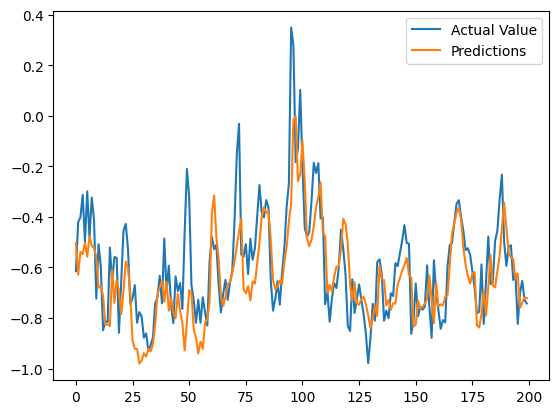

In [12]:
predictions = model.predict(X_test).flatten()
df = pd.DataFrame({'Predictions': predictions, 'Actual Value': y_test})
plt.plot(df['Actual Value'][:200], label='Actual Value')
plt.plot(df['Predictions'][:200], label='Predictions')
plt.legend()
plt.show()

In [13]:
mean_squared_error(y_test, predictions), r2_score(y_test, predictions)
# similar results as predictions basen only on pollution

(np.float64(0.031698313872133496), 0.8774441845952687)

## Forecast

In [69]:
y_pred = []
X_test_autoreg = X_test.copy()

for i in range(window_size, X_test_autoreg.shape[0]-1):  
    # reshape for correct lstm input
    pred = model.predict(X_test_autoreg[i].reshape(1, X_test_autoreg.shape[1], X_test_autoreg.shape[2]), verbose=0)    
    y_pred.append(pred[0, 0]) # it's numpy array, but one value
    if len(y_pred) < 24:
        X_test_autoreg[i+1, -len(y_pred):, 0] = y_pred
    else:
        X_test_autoreg[i+1, :, 0] = y_pred[-window_size:]
    # could be without if: y_pred[-windows_size:] - all, if too small
    # but how many hours at first

In [74]:
X_test - X_test_autoreg

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [78]:
mean_squared_error(y_test[window_size+1:], y_pred), r2_score(y_test[window_size+1: ], y_pred)
# forecast based on weather data, date data and predicted pollution

(np.float64(0.11387863321844137), 0.5614324201641574)

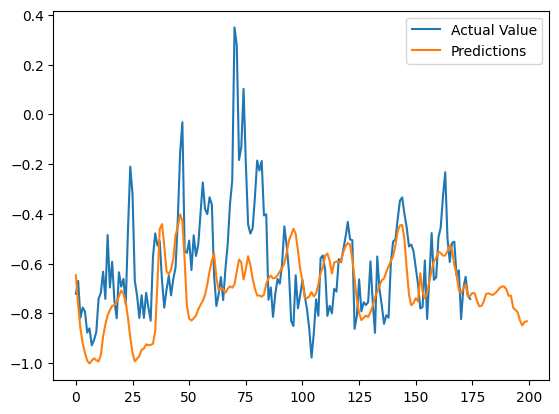

In [80]:
plt.plot(y_test[window_size+1:200], label='Actual Value')
plt.plot(y_pred[:200], label='Predictions')
plt.legend()
plt.show()